In [116]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

In [117]:
df = pd.read_csv('breast-cancer-wisconsin.csv')
df.describe()

,id,mass_thickness,cell_size,cell_shape,edge_adhesion,monolayer_cell_size,dull_chromatin,normal_nucleolus,mitochondria,labels
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [118]:
df = df.drop(['id'],  axis=1) # 删除id项，没有意义的一项
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
mass_thickness         699 non-null int64
cell_size              699 non-null int64
cell_shape             699 non-null int64
edge_adhesion          699 non-null int64
monolayer_cell_size    699 non-null int64
bare_nucleus           699 non-null object
dull_chromatin         699 non-null int64
normal_nucleolus       699 non-null int64
mitochondria           699 non-null int64
labels                 699 non-null int64
dtypes: int64(9), object(1)
memory usage: 54.7+ KB


In [119]:
df = df.replace('?', np.nan)
#df = df.fillna(method='pad')
#df['bare_nucleus'] = pd.to_numeric(df['bare_nucleus'])
df['bare_nucleus'] = pd.to_numeric(df['bare_nucleus'])
df['bare_nucleus'] = df.fillna(df['bare_nucleus'].mean()) # j
df['labels'] = df['labels'].map({2: 0, 4: 1}) # torch的label必须从0开始
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
mass_thickness         699 non-null int64
cell_size              699 non-null int64
cell_shape             699 non-null int64
edge_adhesion          699 non-null int64
monolayer_cell_size    699 non-null int64
bare_nucleus           699 non-null float64
dull_chromatin         699 non-null int64
normal_nucleolus       699 non-null int64
mitochondria           699 non-null int64
labels                 699 non-null int64
dtypes: float64(1), int64(9)
memory usage: 54.7 KB


In [120]:
# 将数据集分成训练集和测试集 默认0.8
def shuffle_data(features: np.array, labels: np.array, test_size=0.8, seed=0):
    np.random.seed(seed) # 随机数种子
    index = list(range(len(features)))
    np.random.shuffle(index) # 随机分配测试集与训练集

    data_size = len(features)
    train_data_size = int(test_size * data_size)

    train_features = features[:train_data_size, :]
    train_labels = labels[:train_data_size]

    test_features = features[train_data_size:, :]
    test_labels = labels[train_data_size:]
    return train_features, train_labels, test_features, test_labels

In [121]:
# numpy转换成torch识别的数据类型
def transfer_torch_data(train_features, train_labels, test_features, test_labels):
    return torch.from_numpy(train_features).float(),torch.from_numpy(train_labels).long(), torch.from_numpy(test_features).float(),torch.from_numpy(test_labels).long()

In [122]:
train_features, train_labels = df.iloc[:, :8], df[df.columns[-1]] # 分离特征和标签
train_features = np.array(train_features)
train_labels = np.array(train_labels)
x_train, y_train, x_test, y_test = shuffle_data(train_features, train_labels, test_size=0.7)
train_features, train_labels, test_features, test_labels = \
        transfer_torch_data(x_train, y_train, x_test, y_test)

In [123]:
# 构建模型 8个特征，1个隐藏层，2类标签
model = nn.Sequential(
        nn.Linear(8, 128),
        nn.Sigmoid(),
        #nn.Linear(128,128),
        #nn.ReLU(),
        nn.Linear(128, 2)
    )
loss = nn.CrossEntropyLoss()  # 损失函数
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01) # 优化器
epochs = 200  # 训练次数
# 开始训练
for each_epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(train_features)
    loss_value = loss(predictions, train_labels)
    loss_value.backward()
    optimizer.step()
    if (each_epoch+1) % 20 == 0:
        print(f"epoch: {each_epoch+1}, loss: {loss_value.data}")
model.eval()

epoch: 20, loss: 0.18603695929050446
epoch: 40, loss: 0.13740386068820953
epoch: 60, loss: 0.12497808784246445
epoch: 80, loss: 0.11944181472063065
epoch: 100, loss: 0.11613418906927109
epoch: 120, loss: 0.11368285119533539
epoch: 140, loss: 0.11149904876947403
epoch: 160, loss: 0.10927186161279678
epoch: 180, loss: 0.106483593583107
epoch: 200, loss: 0.10240908712148666


Sequential(
  (0): Linear(in_features=8, out_features=128, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=128, out_features=2, bias=True)
)

In [124]:
# 预测
predictions = model(test_features).detach().numpy()
predictions = np.argmax(predictions, axis=-1)

In [125]:
# 评价，如果跟标签一致，累加
def eval(predict:list, labels:torch.Tensor):
    labels = labels.data.tolist()
    truth = sum([1 if predict[i] == labels[i] else 0 for i in range(len(labels))]) * 1.0 / len(labels)
    #  predict 和 label 同时为1
    tp = sum([1 if predict[i] == labels[i] and predict[i] == 1 else 0 for i in range(len(labels))])
    #  predict 和 label 同时为0
    tn = sum([1 if predict[i] == labels[i] and predict[i] == 0 else 0 for i in range(len(labels))])
    # predict 0 label 1 预测为正样本，实际为负样本
    fn = sum([1 if predict[i] != labels[i] and predict[i] == 0 else 0 for i in range(len(labels))])
    # predict 1 label 0 预测为负样本，实际为正样本
    fp = sum([1 if predict[i] != labels[i] and predict[i] == 1 else 0 for i in range(len(labels))])
    print('准确度 %f' % truth)
    p = tp * 1.0 / (tp + fp)
    print('精确度 %f' % p)
    r = tp * 1.0 / (tp + fn)
    print('召回率 %f' % r)
    print('F1 %f' % (2 * r * p / (r + p)))
    acc = (tp + tn) / (tp + tn + fp + fn)
    print('准确度 %f' % acc)

In [126]:
eval(predictions, test_labels) # 打印精确度

准确度 0.985714
精确度 0.958333
召回率 0.978723
F1 0.968421
准确度 0.985714


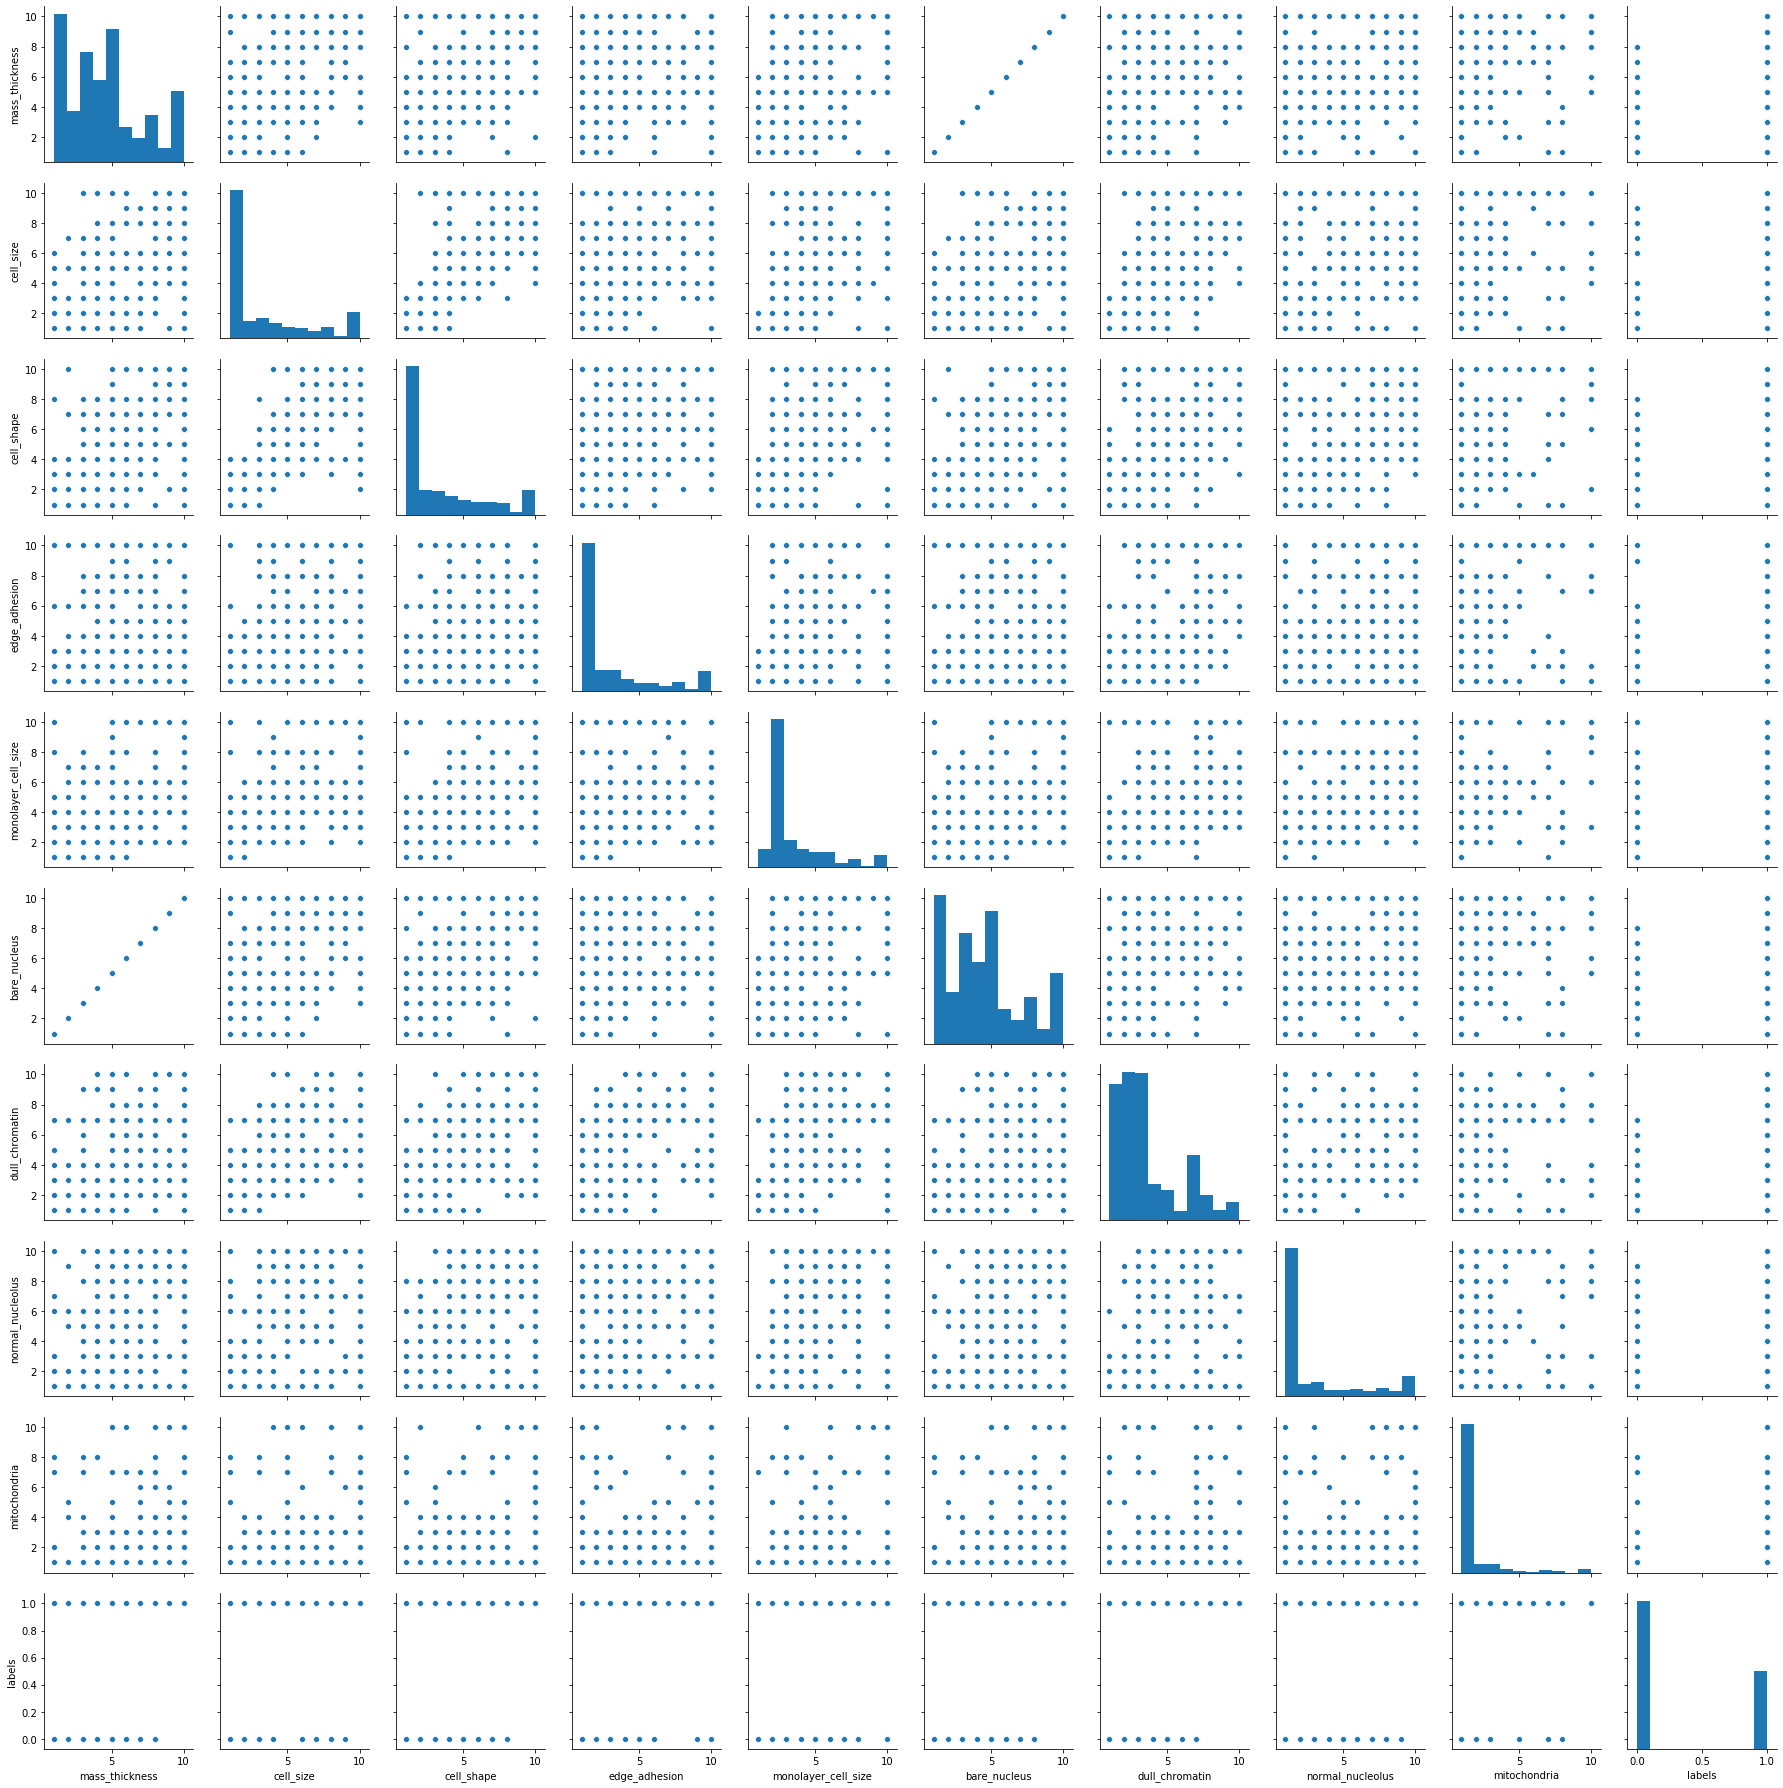

In [46]:
import seaborn as sns

sns.pairplot(df)
plt.show()